# PREDICTING SEPSIS RISK DURING IN-PATIENT ADMISSIONS
*Client: Royal Perth Hospital*

*Team: Group 7*

# EDA in demographic and time - Statistical Summary 

This workbook is for the statistical summary on patients' demographic and time-related data. Different statistical analyses have been experimented and performed here 

# Readme
The following libraries need to be installed in order to run the source code.

In [1]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

np.warnings = warnings

In [2]:
import sys
sys.path.append("..")

# import utility functions
import src.utils as util
reload(util)

import src.load_parquet as load_parquet
reload(load_parquet)

# setup OS agnostic pathnames
ROOT_DIR = Path('..')

# Note: to run main notebook from root directory, use:
# ROOT_DIR = Path('')

import src.DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

import src.modelling_pipeline as models
reload(models)

mp = models.ModelPipeline(ROOT_DIR)

In [3]:
# load libraries and modules
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report 
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay

# 1.Dataset Processing

Load the dataset. The following tables are loaded for this project:
- PATIENTS
- ADMISSIONS
- DIAGNOSES_ICD
- LABEVENTS
- MICROBIOLOGYEVENTS
- D_ICD_DIAGNOSES
- D_ITEMS

In [4]:
path_patients = ROOT_DIR / 'data' / "PATIENTS.csv"  
path_admissions = ROOT_DIR / 'data' / "ADMISSIONS.csv"
path_diagnoses_icd = ROOT_DIR / 'data' / "DIAGNOSES_ICD.csv"
path_labevents = ROOT_DIR / 'data' / "LABEVENTS.csv"
path_microbiologyevents = ROOT_DIR / 'data' / "MICROBIOLOGYEVENTS.csv"
path_desc_icd = ROOT_DIR / 'data' / "D_ICD_DIAGNOSES.csv"
path_desc_labitems = ROOT_DIR / 'data' / "D_LABITEMS.csv"
path_desc_items = ROOT_DIR / 'data' /  "D_ITEMS.csv"

In [5]:
# load transaction dataset
df_patients_full = pd.read_csv(path_patients)
df_admissions_full = pd.read_csv(path_admissions)
df_diagnoses_icd_full = pd.read_csv(path_diagnoses_icd)
df_labevents_full = pd.read_csv(path_labevents)
df_microbiologyevents_full = pd.read_csv(path_microbiologyevents)

# load description tables
df_desc_icd_full = pd.read_csv(path_desc_icd)
df_desc_labitems_full = pd.read_csv(path_desc_labitems)
df_desc_items_full = pd.read_csv(path_desc_items)

## 1.1 Data Cleaning

In [6]:
# Convert the following datetime columns to datetime format
# patients: DOB to date format, we not care about the birth time
df_patients_full['DOB'] = pd.to_datetime(df_patients_full['DOB'], format='%Y-%m-%d %H:%M:%S')
# admissions: ADMITTIME, DISCHTIME, EDREGTIME, EDOUTTIME
df_admissions_full['ADMITTIME'] = pd.to_datetime(df_admissions_full['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')
df_admissions_full['DISCHTIME'] = pd.to_datetime(df_admissions_full['DISCHTIME'], format='%Y-%m-%d %H:%M:%S')
# labevents: CHARTTIME
df_labevents_full['CHARTTIME'] = pd.to_datetime(df_labevents_full['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')
# microbiologyevents: CHARTDATE to date format and CHARTTIME to datetime format
df_microbiologyevents_full['CHARTDATE'] = pd.to_datetime(df_microbiologyevents_full['CHARTDATE'], format='%Y-%m-%d %H:%M:%S')
df_microbiologyevents_full['CHARTTIME'] = pd.to_datetime(df_microbiologyevents_full['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')

The DIAGNOSES_ICD tables has a column ICD9_CODE which is the code for each disease diagnosed for the patient.

The Sepsis has 6 codes: ['77181', '99591', '99592', '67020', '67022', '67024']

We'll introduce a new column, IS_SEPSIS, as a binary classifier (1 for 6 sepsis ICD9 codes, 0 otherwise) for the target variable.

In [7]:
# retrieve all sepsis icd code
sepsis_icd =  df_desc_icd_full[df_desc_icd_full.apply(lambda x:'sepsis' in x['SHORT_TITLE'].lower(),axis=1)]['ICD9_CODE'].values
# add new binary classifier target variable
df_diagnoses_icd_full['IS_SEPSIS'] = df_diagnoses_icd_full.apply(lambda x: 1 if x['ICD9_CODE'] in sepsis_icd else 0, axis=1)

In [8]:
# create function for checking the admission diagnoses to find whether it is diagnosed sepsis
def check_sepsis(subject_id, hadm_id, df_diagnoses_icd):
    admission_diagnoses = df_diagnoses_icd_full[(df_diagnoses_icd_full['SUBJECT_ID'] == subject_id) & (df_diagnoses_icd_full['HADM_ID'] == hadm_id)]
    is_sepsis = 1 if sum(admission_diagnoses['IS_SEPSIS']) > 0 else 0
    return is_sepsis

In [9]:
# create demographic df and save to csv file for future load
try:
    pathname_demographic = ROOT_DIR / 'data' / 'demographic.csv'
    df_demographic_full = pd.read_csv(pathname_demographic)
except:
    # merge the patients and admission tables to a demographic dataframe
    df_demographic_full = pd.merge(df_admissions_full, df_patients_full[['SUBJECT_ID', 'GENDER', 'DOB', 'EXPIRE_FLAG']], on='SUBJECT_ID')
    # create an age column to each case
    df_demographic_full['AGE'] = (((df_demographic_full['ADMITTIME'].dt.date - df_demographic_full['DOB'].dt.date) // 365) / pd.Timedelta(days=1)).astype('int16')
    # add column IS_SEPSIS to demographic data indicating which case is diagnosed with sepsis
    df_demographic_full['IS_SEPSIS'] = df_demographic_full.apply(lambda x: check_sepsis(x['SUBJECT_ID'], x['HADM_ID'], df_diagnoses_icd_full), axis=1)
    util.save_csv(df_demographic_full, ROOT_DIR / 'data' / 'demographic_full.csv')

# convert admittime and dischtime to datetime
df_demographic_full['ADMITTIME'] = pd.to_datetime(df_demographic_full['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')
df_demographic_full['DISCHTIME'] = pd.to_datetime(df_demographic_full['DISCHTIME'], format='%Y-%m-%d %H:%M:%S')

In [10]:
# create age category 
df_demographic_full = util.categorise_age(df_demographic_full)

In [12]:
count_over100 = len(df_demographic_full[df_demographic_full.AGE>100])
p_over100 = len(df_demographic_full[df_demographic_full.AGE>100])/len(df_demographic_full)*100
median_age = int(df_demographic_full['AGE'].median())
print('The number of admissions aged over 100 years old is: {} admissions ({:.2f}% over all admissions)'.format(count_over100, p_over100))
print('The median age of patients: {}'.format(median_age))

The number of admissions aged over 100 years old is: 2616 admissions (4.44% over all admissions)
The median age of patients: 61


Load unpivoted labevents dataframe:

In [13]:
output_dir = ROOT_DIR / 'data' / 'labevents_transform_parquet'
df_labevents_processed = load_parquet.load_labevents_dask(output_dir)

2023-10-22 01:30:35.738861 Start
2023-10-22 01:30:36.345304 2045381
2023-10-22 01:30:41.793236 End


In [14]:
df_labevents_full.head(10)

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,281,3,NaN,50820,2101-10-12 16:07:00,7.39,7.39,units,NaN
1,282,3,NaN,50800,2101-10-12 18:17:00,ART,NaN,NaN,NaN
2,283,3,NaN,50802,2101-10-12 18:17:00,-1,-1.00,mEq/L,NaN
3,284,3,NaN,50804,2101-10-12 18:17:00,22,22.00,mEq/L,NaN
4,285,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,mmol/L,abnormal
5,286,3,NaN,50812,2101-10-12 18:17:00,NOT INTUBATED,NaN,NaN,NaN
6,287,3,NaN,50813,2101-10-12 18:17:00,1.8,1.80,mmol/L,NaN
7,288,3,NaN,50818,2101-10-12 18:17:00,33,33.00,mm Hg,NaN
8,289,3,NaN,50820,2101-10-12 18:17:00,7.42,7.42,units,NaN
9,290,3,NaN,50821,2101-10-12 18:17:00,80,80.00,mm Hg,NaN


In [15]:
# Read LABEVENTS.csv and filter rows where HADM_ID is missing

# Read ADMISSIONS.csv
df_empty_hadm_labevents = df_labevents_full[df_labevents_full['HADM_ID'].isnull()]
df_filled_hadm_labevents = df_labevents_full[pd.to_numeric(df_labevents_full["HADM_ID"], errors='coerce').notnull()]

df_admissions_full.sort_values(by=["SUBJECT_ID", "ADMITTIME"], inplace=True)
df_empty_hadm_labevents.sort_values(by=["SUBJECT_ID", "CHARTTIME"], inplace=True)

# Sorting both DataFrames by the keys used for merging

df_admissions_full['ADMITTIME'] = pd.to_datetime(df_admissions_full['ADMITTIME'])
df_admissions_full['DISCHTIME'] = pd.to_datetime(df_admissions_full['DISCHTIME'])
df_empty_hadm_labevents['CHARTTIME'] = pd.to_datetime(df_empty_hadm_labevents['CHARTTIME']) 

# Merge and fill missing HADM_ID using inner join
merged_data = df_empty_hadm_labevents.merge(df_admissions_full, on='SUBJECT_ID', how='inner')
mask = (merged_data['CHARTTIME'] >= merged_data['ADMITTIME']) & (merged_data['CHARTTIME'] <= merged_data['DISCHTIME'])
#Main Task
#if charttime falls between admission time and discharge time then replace labevents hadm_id with admissions table

#to show all the rows
merged_data.loc[mask, 'HADM_ID_x'] = merged_data.loc[mask, 'HADM_ID_y']

# Rename the column back to 'HADM_ID'
merged_data.rename(columns={'HADM_ID_x': 'HADM_ID'}, inplace=True)

# Drop unnecessary columns
merged_data.sort_values(by=["ROW_ID_x"], inplace=True)
merged_data.drop(['HADM_ID_y', 'ROW_ID_y'], axis=1, inplace=True)
merged_data.rename(columns={'SUBJECT_ID_y': 'ADMISSION_SUBJECT_ID'}, inplace=True)

filtered_data_hasHADM = merged_data[merged_data['HADM_ID'].notna()].drop_duplicates(subset=['ROW_ID_x']) #NEED TO CHECK IF unnecessary rows are present since we used merge with adissions and lab events before
filtered_data_noHADM = merged_data[merged_data['HADM_ID'].isnull()].drop_duplicates(subset=['ROW_ID_x'])
filtered_data_hasHADM.rename(columns={'ROW_ID_x': 'ROW_ID'}, inplace=True)
filtered_data_noHADM.rename(columns={'ROW_ID_x': 'ROW_ID'}, inplace=True)

row_ids_in_hasHADM = set(filtered_data_hasHADM['ROW_ID'])
filtered_data_noHADM = filtered_data_noHADM[~filtered_data_noHADM['ROW_ID'].isin(row_ids_in_hasHADM)] #Had to refilter filtered_data_noHADM since there were unnecessary rows

columns_to_remove = ['ADMITTIME','DISCHTIME','DEATHTIME', 'ADMISSION_TYPE',  'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE',    'LANGUAGE', 'RELIGION', 'MARITAL_STATUS',   'ETHNICITY', 'EDREGTIME'    ,'EDOUTTIME'    ,'DIAGNOSIS'    ,'HOSPITAL_EXPIRE_FLAG' ,'HAS_CHARTEVENTS_DATA']

# Drop the specified columns
filtered_data_noHADM = filtered_data_noHADM.drop(columns=columns_to_remove)
filtered_data_hasHADM = filtered_data_hasHADM.drop(columns=columns_to_remove)

# filtered_data_hasHADM.to_csv('filtered_data_hasHADM.csv', index=False)
# filtered_data_noHADM.to_csv('filtered_data_noHADM.csv', index=False)

#Uncomment these if you want to export to CSV
# filtered_data_hasHADM.to_csv('filtered_data_hasHADM.csv', index=False)
# filtered_data_noHADM.to_csv('filtered_data_noHADM.csv', index=False)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
# FINAL these three together is the total lab_events len(df_filled_hadm_labevents) + len(filtered_data_hasHADM) + len(filtered_data_noHADM)

combined_df_hasHADM = pd.concat([df_filled_hadm_labevents, filtered_data_hasHADM], ignore_index=True)
combined_df_hasHADM['HADM_ID'] = combined_df_hasHADM['HADM_ID'].astype(int)

In [17]:
df_labevents_clean1 = combined_df_hasHADM
# Merge LABEVENTS with ADMISSIONS on SUBJECT_ID and HADM_ID
combined_df = df_labevents_clean1.merge(df_admissions_full[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME']], 
                               on=['SUBJECT_ID', 'HADM_ID'], 
                               how='left')

# Match to our ground truth IS_SEPSIS
combined_df = combined_df.merge(df_demographic_full[['SUBJECT_ID', 'HADM_ID','IS_SEPSIS']], 
                               on=['SUBJECT_ID', 'HADM_ID'], 
                               how='left')
combined_df.head(10)

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,ADMITTIME,DISCHTIME,IS_SEPSIS
0,441,3,145834,50868,2101-10-20 16:40:00,17,17.0,mEq/L,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,0
1,442,3,145834,50882,2101-10-20 16:40:00,25,25.0,mEq/L,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,0
2,443,3,145834,50893,2101-10-20 16:40:00,8.2,8.2,mg/dL,abnormal,2101-10-20 19:08:00,2101-10-31 13:58:00,0
3,444,3,145834,50902,2101-10-20 16:40:00,99,99.0,mEq/L,abnormal,2101-10-20 19:08:00,2101-10-31 13:58:00,0
4,445,3,145834,50910,2101-10-20 16:40:00,48,48.0,IU/L,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,0
5,446,3,145834,50911,2101-10-20 16:40:00,NotDone,NaN,ng/mL,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,0
6,447,3,145834,50912,2101-10-20 16:40:00,3.2,3.2,mg/dL,abnormal,2101-10-20 19:08:00,2101-10-31 13:58:00,0
7,448,3,145834,50931,2101-10-20 16:40:00,91,91.0,mg/dL,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,0
8,449,3,145834,50960,2101-10-20 16:40:00,2.4,2.4,mg/dL,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,0
9,450,3,145834,50970,2101-10-20 16:40:00,4.8,4.8,mg/dL,abnormal,2101-10-20 19:08:00,2101-10-31 13:58:00,0


## 1.2 Data Exploration

### 1.2.1 Statistics table

In [18]:
# Sepsis vs Non-sepsis (n)
total_counts = len(df_demographic_full)
label_counts = df_demographic_full["IS_SEPSIS"].value_counts()
label_portion = [round(label_counts[0]/total_counts*100, 2), 
                 round(label_counts[1]/total_counts*100, 2)]
label_dict = {0:"No_sepsis", 1: "Sepsis"}

In [19]:
total_counts

58976

In [20]:
# Age (years, median)
age_crosstab = pd.crosstab(df_demographic_full["IS_SEPSIS"], df_demographic_full["AGE"])
age_crosstab

AGE,0,14,15,16,17,18,19,20,21,22,...,302,303,304,305,306,307,308,309,310,311
IS_SEPSIS,,,,,,,,,,,,,,,,,,,,,
0,7880,1,8,22,69,127,150,187,205,204,...,52,42,32,16,20,18,10,5,4,1
1,230,0,0,0,0,6,3,9,7,10,...,25,6,10,6,6,3,2,1,1,0


In [21]:
# For Non-Sepsis group
non_sepsis_ages = []
for age, count in enumerate(age_crosstab.loc[0]):
    non_sepsis_ages.extend([age] * count)
non_sepsis_median = np.median(non_sepsis_ages)

# For Sepsis group
sepsis_ages = []
for age, count in enumerate(age_crosstab.loc[1]):
    sepsis_ages.extend([age] * count)
sepsis_median = np.median(sepsis_ages)

print(f"Median Age for Non-Sepsis: {non_sepsis_median}")
print(f"Median Age for Sepsis: {sepsis_median}")

Median Age for Non-Sepsis: 48.0
Median Age for Sepsis: 54.0


In [22]:
# Create an age category column
df_demographic_full['Age_Category'] = np.where(df_demographic_full['AGE'] < 18, '<18', '18+')

# Group by IS_SEPSIS and Age_Category, then calculate the median age for each group
median_ages = df_demographic_full.groupby(['IS_SEPSIS', 'Age_Category'])['AGE'].median().reset_index()

median_ages

,IS_SEPSIS,Age_Category,AGE
0,0,18+,65.0
1,0,<18,0.0
2,1,18+,68.0
3,1,<18,0.0


In [23]:
# Extracting median age values
median_age_non_sepsis_18plus = round(median_ages[(median_ages['IS_SEPSIS'] == 0) & (median_ages['Age_Category'] == '18+')]['AGE'].values[0],0)
median_age_non_sepsis_less18 = round(median_ages[(median_ages['IS_SEPSIS'] == 0) & (median_ages['Age_Category'] == '<18')]['AGE'].values[0],0)
median_age_sepsis_18plus = round(median_ages[(median_ages['IS_SEPSIS'] == 1) & (median_ages['Age_Category'] == '18+')]['AGE'].values[0],0)
median_age_sepsis_less18 = round(median_ages[(median_ages['IS_SEPSIS'] == 1) & (median_ages['Age_Category'] == '<18')]['AGE'].values[0],0)

In [24]:
# p-value of Age (Mann-Whitney U test because the data isn't normally distributed):
from scipy.stats import ttest_ind, chi2_contingency, mannwhitneyu

u_stat, p_value_age = mannwhitneyu(sepsis_ages, non_sepsis_ages)
p_value_age

2.6428965824693947e-121

In [25]:
# Gender (n, %)
gender_counts = df_demographic_full["GENDER"].value_counts()
gender_portion = [round(gender_counts[0]/total_counts*100, 2), 
                 round(gender_counts[1]/total_counts*100, 2)]
gender_dict = {"M":"Male", "F": "Female"}
gender_long_labels = df_demographic_full['GENDER'].map(gender_dict)

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [26]:
gender_crosstab = pd.crosstab(df_demographic_full["IS_SEPSIS"], df_demographic_full["GENDER"])
gender_crosstab_percentage = round(gender_crosstab.div(gender_crosstab.sum(axis=1), axis=0) * 100,2)
gender_crosstab

GENDER,F,M
IS_SEPSIS,,
0,23623,29947
1,2403,3003


In [27]:
# p-value of Gender (using chi-squared test):

gender_contingency_table = [[2403, 3003],
                           [23623, 29937]]
chi2, p_value_gender, _, _ = chi2_contingency(gender_contingency_table)
p_value_gender = round(p_value_gender, 2)
p_value_gender

0.64

In [28]:
# Mortality rate (IS_SEPSIS and EXPIRE_FLAG)
mortality_crosstab = pd.crosstab(df_demographic_full["IS_SEPSIS"], df_demographic_full["EXPIRE_FLAG"])
mortality_crosstab_percentage = round(mortality_crosstab.div(mortality_crosstab.sum(axis=1), axis=0) * 100,2)
mortality_crosstab

EXPIRE_FLAG,0,1
IS_SEPSIS,,
0,34276,19294
1,2114,3292


In [29]:
# p-value of Mortality rate (using chi-squared test):

gender_contingency_table = [[2403, 3003],
                           [23623, 29937]]
chi2, p_value_gender, _, _ = chi2_contingency(gender_contingency_table)
p_value_gender = round(p_value_gender, 2)
p_value_gender

0.64

In [30]:
# First blood test since admission (hours, mean) - We have excluded the rows without HADM_ID in the labevent table

# Merge the two dataframes on ITEMID
first_blood_df = combined_df.merge(df_desc_labitems_full[['ITEMID', 'FLUID']], on='ITEMID', how='left')

# Filter all the blood tests
first_blood_df = first_blood_df[first_blood_df['FLUID'] == 'Blood']

# Sort by HADM_ID and CHARTTIME
first_blood_df = first_blood_df.sort_values(by=['HADM_ID', 'CHARTTIME'])

# Take the first entry for each HADM_ID
first_blood_df = first_blood_df.groupby('HADM_ID').first().reset_index()

# Calculate the time of the first blood test
def calculate_time(row):
    if row['CHARTTIME'] < row['ADMITTIME']:
        return 0
    else:
        return (row['CHARTTIME'] - row['ADMITTIME']).total_seconds() / 3600  # Convert timedelta to hours

first_blood_df['Time_First_Blood_Test'] = first_blood_df.apply(calculate_time, axis=1)


In [31]:
# Separate the data into sepsis and non-sepsis groups based on Time_First_Blood_Test
first_blood_sepsis = first_blood_df[first_blood_df['IS_SEPSIS'] == 1]['Time_First_Blood_Test']
first_blood_non_sepsis = first_blood_df[first_blood_df['IS_SEPSIS'] == 0]['Time_First_Blood_Test']

In [32]:
mean_times = first_blood_df.groupby('IS_SEPSIS')['Time_First_Blood_Test'].mean()

mean_time_sepsis = round(mean_times[1],2)
mean_time_non_sepsis = round(mean_times[0],2)

print(f"Mean Time for First Blood Test for Sepsis: {mean_time_sepsis:.2f} hours")
print(f"Mean Time for First Blood Test for Non-Sepsis: {mean_time_non_sepsis:.2f} hours")

Mean Time for First Blood Test for Sepsis: 0.84 hours
Mean Time for First Blood Test for Non-Sepsis: 2.41 hours


In [33]:
median_times = first_blood_df.groupby('IS_SEPSIS')['Time_First_Blood_Test'].median()

median_time_sepsis = round(median_times[1],2)
median_time_non_sepsis = round(median_times[0],2)

print(f"Median Time for First Blood Test for Sepsis: {median_time_sepsis:.2f} hours")
print(f"Median Time for First Blood Test for Non-Sepsis: {median_time_non_sepsis:.2f} hours")

Median Time for First Blood Test for Sepsis: 0.00 hours
Median Time for First Blood Test for Non-Sepsis: 0.00 hours


In [34]:
# Admission length of stay (days, mean)
first_blood_df['LENGTH_OF_STAY'] = (first_blood_df['DISCHTIME'] - first_blood_df['ADMITTIME']).dt.total_seconds() / (3600 * 24)  # Convert timedelta to days

mean_stay = first_blood_df.groupby('IS_SEPSIS')['LENGTH_OF_STAY'].mean()

mean_stay_sepsis = round(mean_stay[1],2)
mean_stay_non_sepsis = round(mean_stay[0],2)

print(f"Mean Days of Stay for Sepsis: {mean_stay_sepsis:.2f} days")
print(f"Mean Days of Stay for Non-Sepsis: {mean_stay_non_sepsis:.2f} days")

Mean Days of Stay for Sepsis: 16.74 days
Mean Days of Stay for Non-Sepsis: 9.53 days


In [35]:
# Admission length of stay (days, median)
first_blood_df['LENGTH_OF_STAY'] = (first_blood_df['DISCHTIME'] - first_blood_df['ADMITTIME']).dt.total_seconds() / (3600 * 24)  # Convert timedelta to days

median_stay = first_blood_df.groupby('IS_SEPSIS')['LENGTH_OF_STAY'].median()

median_stay_sepsis = round(median_stay[1],2)
median_stay_non_sepsis = round(median_stay[0],2)

print(f"Median Days of Stay for Sepsis: {median_stay_sepsis:.2f} days")
print(f"Median Days of Stay for Non-Sepsis: {median_stay_non_sepsis:.2f} days")

Median Days of Stay for Sepsis: 10.07 days
Median Days of Stay for Non-Sepsis: 6.23 days


In [36]:
# p-value of length of stay (Mann-Whitney U test because the data isn't normally distributed):

# Separate the data into sepsis and non-sepsis groups based on LENGTH_OF_STAY
stay_sepsis = first_blood_df[first_blood_df['IS_SEPSIS'] == 1]['LENGTH_OF_STAY']
stay_non_sepsis = first_blood_df[first_blood_df['IS_SEPSIS'] == 0]['LENGTH_OF_STAY']

u_stat_stay, p_value_stay = mannwhitneyu(stay_sepsis, stay_non_sepsis)
p_value_stay

3.0306802540614646e-280

In [37]:
import statsmodels.api as sm

# Prepare the data
X = first_blood_df['LENGTH_OF_STAY']
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = first_blood_df['IS_SEPSIS']

# Fit logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Display results
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.299627
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              IS_SEPSIS   No. Observations:                58167
Model:                          Logit   Df Residuals:                    58165
Method:                           MLE   Df Model:                            1
Date:                Sun, 22 Oct 2023   Pseudo R-squ.:                 0.03086
Time:                        01:32:51   Log-Likelihood:                -17428.
converged:                       True   LL-Null:                       -17983.
Covariance Type:            nonrobust   LLR p-value:                2.191e-243
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6279      0.019   -141.478      0.000      -2.664      -2.591
LENGTH_OF_STAY   

In [38]:
# Statistic table

demographic_stat_data = {
  'Variable': ['n', 
               'Age (years, median)',
               '  <18',
               '  18+', 
               'Female (n, %)', 
               'Mortality Rate (n, %)',
               'Admission length of stay (days, mean)', 
               'First blood test since admission (hours, mean)'],
  'Sepsis': [label_counts[1], 
             '',  # Empty cell for main Age group
             median_age_sepsis_less18, 
             median_age_sepsis_18plus, 
             f"{gender_crosstab['F'][1]} ({gender_crosstab_percentage['F'][1]}%)", 
             f"{mortality_crosstab[1][1]} ({mortality_crosstab_percentage[1][1]}%)",
             mean_stay_sepsis,
             mean_time_sepsis],
  'Non-Sepsis': [label_counts[0], 
                 '',  # Empty cell for main Age group
                 median_age_non_sepsis_less18, 
                 median_age_non_sepsis_18plus, 
                 f"{gender_crosstab['F'][0]} ({gender_crosstab_percentage['F'][0]}%)", 
                 f"{mortality_crosstab[1][0]} ({mortality_crosstab_percentage[1][0]}%)", 
                 mean_stay_non_sepsis,
                 mean_time_non_sepsis],
  'p': ['', # no values to compute for number of counts of sepsis / non-sepsis
        '<0.0001', # refer to p_value_age
        '', # overall age p-value is computed
        '', # overall age p-value is computed
        p_value_gender,
        '', # there is no need for p-value in Mortality rate
        '',
        '' # there is no need for p-value in 1st blood test time
        ]
                
}

demographic_stat_df = pd.DataFrame(demographic_stat_data)
print(tabulate(demographic_stat_df, headers='keys', tablefmt='pipe', showindex=False))

| Variable                                       | Sepsis        | Non-Sepsis     | p       |
|:-----------------------------------------------|:--------------|:---------------|:--------|
| n                                              | 5406          | 53570          |         |
| Age (years, median)                            |               |                | <0.0001 |
| <18                                            | 0.0           | 0.0            |         |
| 18+                                            | 68.0          | 65.0           |         |
| Female (n, %)                                  | 2403 (44.45%) | 23623 (44.1%)  | 0.64    |
| Mortality Rate (n, %)                          | 3292 (60.9%)  | 19294 (36.02%) |         |
| Admission length of stay (days, mean)          | 16.74         | 9.53           |         |
| First blood test since admission (hours, mean) | 0.84          | 2.41           |         |


In [39]:
# Convert the table to LaTeX format to import to Overleaf
demographic_latex_table = demographic_stat_df.to_latex(index=False, escape=False, caption="Summary of characteristics of MIMIC III dataset")

print(demographic_latex_table)

\begin{table}
\caption{Summary of characteristics of MIMIC III dataset}
\begin{tabular}{llll}
\toprule
Variable & Sepsis & Non-Sepsis & p \\
\midrule
n & 5406 & 53570 &  \\
Age (years, median) &  &  & <0.0001 \\
  <18 & 0.000000 & 0.000000 &  \\
  18+ & 68.000000 & 65.000000 &  \\
Female (n, %) & 2403 (44.45%) & 23623 (44.1%) & 0.640000 \\
Mortality Rate (n, %) & 3292 (60.9%) & 19294 (36.02%) &  \\
Admission length of stay (days, mean) & 16.740000 & 9.530000 &  \\
First blood test since admission (hours, mean) & 0.840000 & 2.410000 &  \\
\bottomrule
\end{tabular}
\end{table}



### 1.2.2 Age

In [40]:
def categorise_age(df):
    """
    Categorise the 'AGE' column in the DataFrame into age bins.
    
    Parameters:
    - df: DataFrame containing the 'AGE' column
    
    Returns:
    - DataFrame with an additional 'AGE_cat' column containing the age categories
    """

    # define age bin edges
    age_bin_edges = [0, 18, 320]
    
    # define bin labels: neonatal, child, adult, middle-age, elderly, very old
    age_bin_labels = ['<18', '18+']
    
    # create age bins
    df_demographic_full['AGE_cat'] = pd.cut(df_demographic_full['AGE'], bins=age_bin_edges, labels=age_bin_labels, right=False)
    
    return df

In [41]:
categorise_age(df_demographic_full)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,GENDER,DOB,EXPIRE_FLAG,AGE,IS_SEPSIS,AGE_cat,Age_Category
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,BENZODIAZEPINE OVERDOSE,0,1,F,2131-05-07,0,64,0,18+,18+
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,M,2082-07-17,0,71,0,18+,18+
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,BRAIN MASS,0,1,M,2082-07-17,0,75,0,18+,18+
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,INTERIOR MYOCARDIAL INFARCTION,0,1,M,2100-05-31,0,39,0,18+,18+
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,ACUTE CORONARY SYNDROME,0,1,M,2101-11-21,0,58,0,18+,18+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58592,98794,190603,2127-11-07 11:00:00,2127-11-11 14:30:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,AORTIC STENOSIS\AORTIC VALVE REPLACEMENT /SDA,0,1,M,2049-07-29,0,78,0,18+,18+
58972,58593,98797,105447,2132-12-24 20:06:00,2132-12-25 12:00:00,2132-12-25 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,...,ALTERED MENTAL STATUS,1,1,M,2044-12-27,1,88,1,18+,18+
58973,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,TRAUMA,0,1,F,2111-11-05,0,19,0,18+,18+
58974,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,...,SAH,1,1,F,2067-09-21,1,83,0,18+,18+


In [42]:
# Calculate the counts for each age group
age_cat_counts = df_demographic_full['AGE_cat'].value_counts()

# Sort the age groups based on their labels
age_cat_counts = age_cat_counts.sort_index()


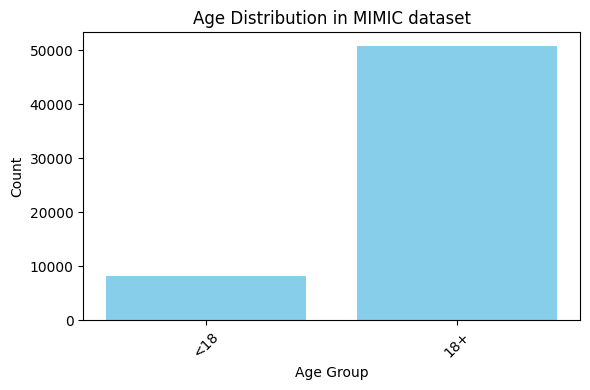

In [43]:
# Create a bar chart
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
plt.bar(age_cat_counts.index, age_cat_counts.values, color='skyblue')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Distribution in MIMIC dataset')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

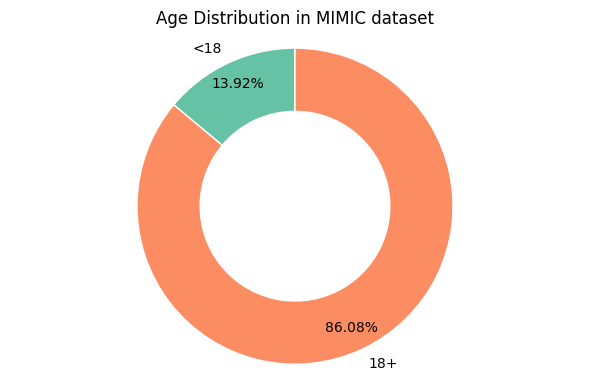

In [44]:
# Calculate the counts for each age group
age_group_counts = df_demographic_full['AGE_cat'].value_counts()

# Sort the age groups based on their labels
age_group_counts = age_group_counts.sort_index()

# Create a donut chart
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
colors = sns.color_palette("Set2")
plt.pie(age_group_counts.values, labels=age_group_counts.index, colors=colors, autopct='%1.2f%%', startangle=90,
        pctdistance=0.85, wedgeprops=dict(width=0.4, edgecolor='w'))

# Draw a white circle in the center to create the donut effect
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Add a title
plt.title('Age Distribution in MIMIC dataset')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

plt.tight_layout()
plt.show()

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


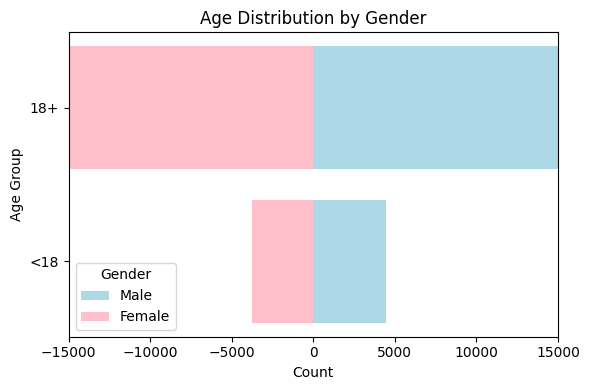

In [45]:
# Sort the DataFrame by 'AgeGroup' column
df_demographic_full.sort_values(by='AGE_cat', inplace=True)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Count the number of observations for each AgeGroup and GENDER
age_gender_counts = df_demographic_full.groupby(['AGE_cat', 'GENDER']).size().unstack().reset_index()

# Create side-by-side bars for males and females with opposite directions
ax.barh(age_gender_counts['AGE_cat'], age_gender_counts['M'], color="lightblue", label='Male')
ax.barh(age_gender_counts['AGE_cat'], -age_gender_counts['F'], color="pink", label='Female')

# Set labels, title, and legend
ax.set_xlabel('Count')
ax.set_ylabel('Age Group')
ax.set_title('Age Distribution by Gender')
ax.legend(title='Gender')

# Set symmetric x-axis limits
ax.set_xlim(-15000, 15000)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()